In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# MNIST Image Classification:

In [165]:
# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Split the dataset into training, validation, and testing sets
train_size = int(0.7 * len(mnist_dataset))
val_size = int(0.1 * len(mnist_dataset))
test_size = len(mnist_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(mnist_dataset, [train_size, val_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [72]:
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)  # First fully connected layer
        self.fc2 = nn.Linear(256, 128)    # Second fully connected layer
        self.fc3 = nn.Linear(128, 64)     # Third fully connected layer
        self.fc4 = nn.Linear(64, 10)      # Output layer for 10 classes (digits 0-9)
    
    def forward(self, x):
        x = x.view(-1, 28*28)             # Flatten the image (28x28 -> 784)
        x = torch.relu(self.fc1(x))       # Apply ReLU activation
        x = torch.relu(self.fc2(x))       # Apply ReLU activation
        x = torch.relu(self.fc3(x))       # Apply ReLU activation
        x = self.fc4(x)                   # Output layer (logits for 10 classes)
        return x, None,None                    # Return logits and None for bottleneck

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Bottleneck layer
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x1 = torch.relu(self.conv1(x))  
        x2 = torch.relu(self.conv2(torch.max_pool2d(x1, 2)))  
        x3 = torch.max_pool2d(x2, 2)
        x4 = x3.view(x3.size(0), -1)
        bottleneck = torch.relu(self.fc1(x4))  # Extract bottleneck features
        logits = self.fc2(bottleneck)  

        return logits, bottleneck, [x1, x2]  # Return logits, bottleneck, and feature maps

class ViT(nn.Module):
    def __init__(self, image_size=28, patch_size=7, num_classes=10, d_model=64, num_heads=4, num_layers=2):
        super(ViT, self).__init__()
        self.patch_size = patch_size
        self.num_patches = (image_size // patch_size) ** 2
        self.embedding = nn.Linear(patch_size * patch_size, d_model)
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        self.position_embeddings = nn.Parameter(torch.randn(1, self.num_patches + 1, d_model))
        self.transformer_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads, dim_feedforward=128, dropout=0.1)
            for _ in range(num_layers)
        ])
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        patches = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(x.size(0), self.num_patches, -1)

        patches = self.embedding(patches)
        cls_tokens = self.cls_token.expand(x.size(0), -1, -1)
        x = torch.cat((cls_tokens, patches), dim=1) + self.position_embeddings
        feature_maps = []  # List to store feature maps from each layer
        for layer in self.transformer_layers:
            x = layer(x)
            feature_maps.append(x)  # Append the feature maps after each layer
        cls_representation = x[:, 0]  # Extract CLS token
        logits = self.fc(cls_representation)
        return logits, cls_representation, feature_maps  # Return logits, CLS token, and intermediate feature maps


# Function to train and evaluate a model
def train_and_evaluate(model, train_loader, val_loader, test_loader, num_epochs=25):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs,_,_ = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs,_,_ = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))
        
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}')

    # Evaluate the model on the test set
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs,_,_ = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    print(f'Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy:.2f}%')
    return test_accuracy, sum(p.numel() for p in model.parameters()), train_losses, val_losses

Choice of Hyperparamters
* learning rate = 0.001 Since the MNIST dataset is relatively small and straightforward, a moderate learning rate like 0.001 allows the models to converge efficiently without overshooting the optimal point.
* Adam works well as it helps the model converge quickly without requiring detailed hyperparameter tuning. Since MNIST is relatively simple and low-dimensional, Adam offers fast convergence without overfitting.
* A batch size of 64 strikes a balance between memory usage and computational efficiency. Since MNIST is less dataset 64 is suffiecient
* Epochs were set to 25 as for ViT it is taking more time to train and evaluate
* Cross ENtropy was choosen based on the requirement in the question.

Epoch 1/25, Training Loss: 0.4519, Validation Loss: 0.2439
Epoch 2/25, Training Loss: 0.1967, Validation Loss: 0.1585
Epoch 3/25, Training Loss: 0.1435, Validation Loss: 0.1487
Epoch 4/25, Training Loss: 0.1171, Validation Loss: 0.1710
Epoch 5/25, Training Loss: 0.1000, Validation Loss: 0.1179
Epoch 6/25, Training Loss: 0.0866, Validation Loss: 0.1388
Epoch 7/25, Training Loss: 0.0789, Validation Loss: 0.1504
Epoch 8/25, Training Loss: 0.0669, Validation Loss: 0.1163
Epoch 9/25, Training Loss: 0.0604, Validation Loss: 0.1477
Epoch 10/25, Training Loss: 0.0552, Validation Loss: 0.1198
Epoch 11/25, Training Loss: 0.0514, Validation Loss: 0.1456
Epoch 12/25, Training Loss: 0.0457, Validation Loss: 0.1034
Epoch 13/25, Training Loss: 0.0401, Validation Loss: 0.1206
Epoch 14/25, Training Loss: 0.0388, Validation Loss: 0.1355
Epoch 15/25, Training Loss: 0.0361, Validation Loss: 0.1217
Epoch 16/25, Training Loss: 0.0362, Validation Loss: 0.1174
Epoch 17/25, Training Loss: 0.0326, Validation Lo

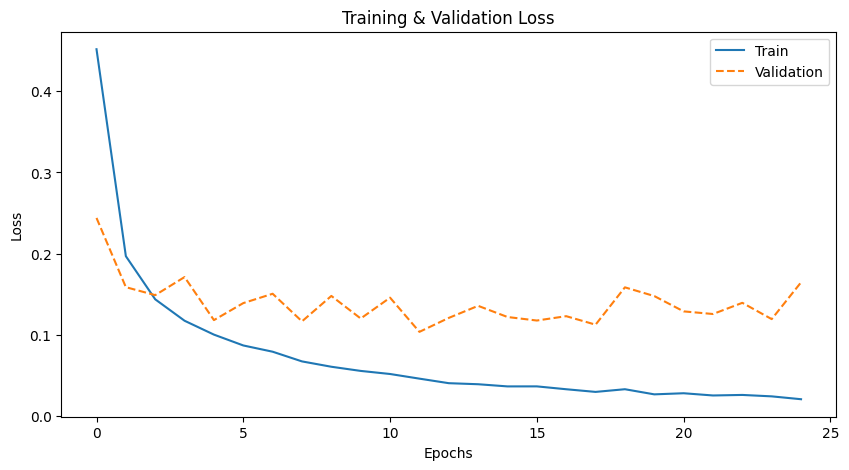

In [35]:
# Train and evaluate ANN
ann_model = ANN()
ann_accuracy, ann_params,ann_train_loss,ann_val_loss = train_and_evaluate(ann_model, train_loader, val_loader, test_loader, num_epochs=25)
# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(ann_train_loss, label=f"Train")
plt.plot(ann_val_loss, label=f"Validation", linestyle="dashed")     
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")
plt.show()

Epoch 1/25, Training Loss: 0.1905, Validation Loss: 0.0775
Epoch 2/25, Training Loss: 0.0546, Validation Loss: 0.0533
Epoch 3/25, Training Loss: 0.0365, Validation Loss: 0.0459
Epoch 4/25, Training Loss: 0.0277, Validation Loss: 0.0538
Epoch 5/25, Training Loss: 0.0212, Validation Loss: 0.0593
Epoch 6/25, Training Loss: 0.0192, Validation Loss: 0.0488
Epoch 7/25, Training Loss: 0.0125, Validation Loss: 0.0548
Epoch 8/25, Training Loss: 0.0113, Validation Loss: 0.0531
Epoch 9/25, Training Loss: 0.0088, Validation Loss: 0.0542
Epoch 10/25, Training Loss: 0.0086, Validation Loss: 0.0523
Epoch 11/25, Training Loss: 0.0076, Validation Loss: 0.0640
Epoch 12/25, Training Loss: 0.0073, Validation Loss: 0.0572
Epoch 13/25, Training Loss: 0.0075, Validation Loss: 0.0575
Epoch 14/25, Training Loss: 0.0055, Validation Loss: 0.0615
Epoch 15/25, Training Loss: 0.0059, Validation Loss: 0.0825
Epoch 16/25, Training Loss: 0.0044, Validation Loss: 0.0703
Epoch 17/25, Training Loss: 0.0038, Validation Lo

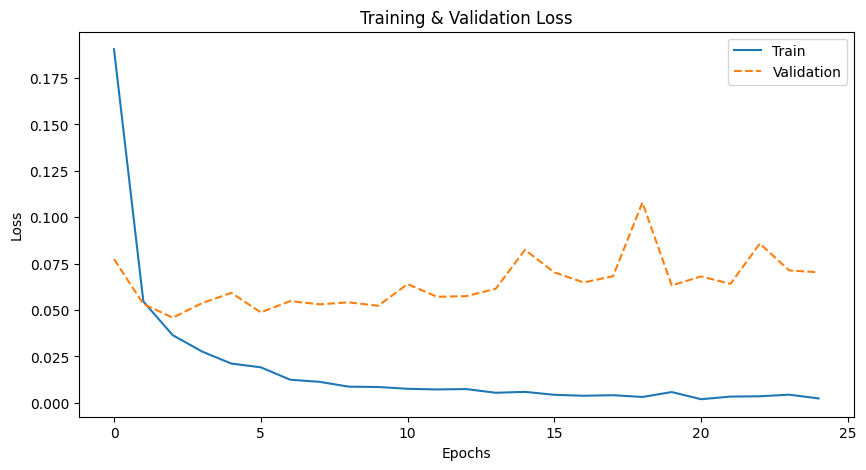

In [36]:
# Train and evaluate CNN
cnn_model = CNN()
cnn_accuracy, cnn_params,cnn_train_loss,cnn_val_loss = train_and_evaluate(cnn_model, train_loader, val_loader, test_loader, num_epochs=25)
# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(cnn_train_loss, label=f"Train")
plt.plot(cnn_val_loss, label=f"Validation", linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")
plt.show()

Epoch 1/25, Training Loss: 2.3157, Validation Loss: 2.3034
Epoch 2/25, Training Loss: 2.3078, Validation Loss: 2.3088
Epoch 3/25, Training Loss: 2.3071, Validation Loss: 2.3031
Epoch 4/25, Training Loss: 2.3057, Validation Loss: 2.3036
Epoch 5/25, Training Loss: 2.3043, Validation Loss: 2.3055
Epoch 6/25, Training Loss: 2.3040, Validation Loss: 2.3057
Epoch 7/25, Training Loss: 2.3038, Validation Loss: 2.3045
Epoch 8/25, Training Loss: 2.3028, Validation Loss: 2.3021
Epoch 9/25, Training Loss: 2.3025, Validation Loss: 2.3035
Epoch 10/25, Training Loss: 2.3024, Validation Loss: 2.3017
Epoch 11/25, Training Loss: 2.3021, Validation Loss: 2.3014
Epoch 12/25, Training Loss: 2.3020, Validation Loss: 2.3015
Epoch 13/25, Training Loss: 2.3017, Validation Loss: 2.3024
Epoch 14/25, Training Loss: 2.3017, Validation Loss: 2.3033
Epoch 15/25, Training Loss: 2.3017, Validation Loss: 2.3023
Epoch 16/25, Training Loss: 2.3017, Validation Loss: 2.3021
Epoch 17/25, Training Loss: 2.3017, Validation Lo

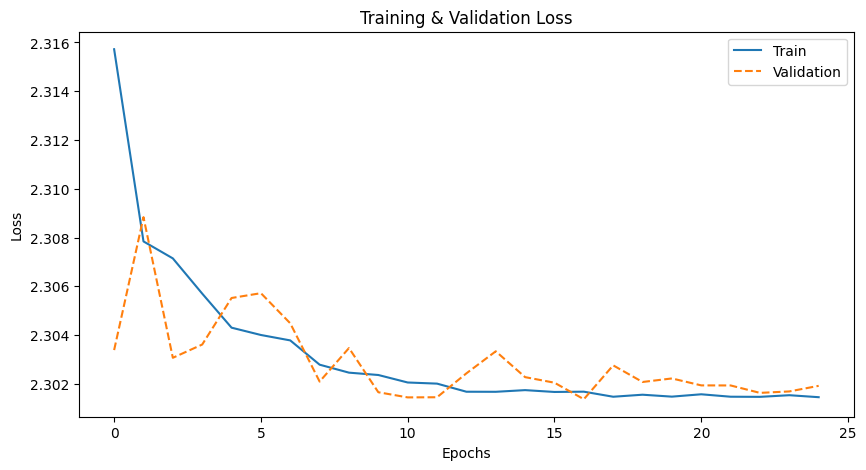

In [73]:
# Train and evaluate ViT
vit_model = ViT()
vit_accuracy, vit_params,vit_train_loss,vit_val_loss = train_and_evaluate(vit_model, train_loader, val_loader, test_loader, num_epochs=25)
# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(vit_train_loss, label=f"Train")
plt.plot(vit_val_loss, label=f"Validation", linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")
plt.show()

# Note :
* Because of device constraints ViT layers and heads were decreased which made ViT works more worser.

In [38]:
if ann_accuracy > cnn_accuracy and ann_accuracy > vit_accuracy:
    print(f"ANN achieved the highest accuracy of {ann_accuracy:.2f}% with {ann_params} parameters.")
elif cnn_accuracy > ann_accuracy and cnn_accuracy > vit_accuracy:
    print(f"CNN achieved the highest accuracy of {cnn_accuracy:.2f}% with {cnn_params} parameters.")
else:
    print(f"ViT achieved the highest accuracy of {vit_accuracy:.2f}% with {vit_params} parameters.")

CNN achieved the highest accuracy of 98.97% with 421642 parameters.


In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

cnn_model = CNN().to(device)
ann_model = ANN().to(device)
vit_model = ViT().to(device)

cnn_params = count_parameters(cnn_model)
ann_params = count_parameters(ann_model)
vit_params = count_parameters(vit_model)

print(f"ANN Parameters: {ann_params:,}")
print(f"CNN Parameters: {cnn_params:,}")
print(f"ViT Parameters: {vit_params:,}")

ANN Parameters: 242,762
CNN Parameters: 421,642
ViT Parameters: 71,946


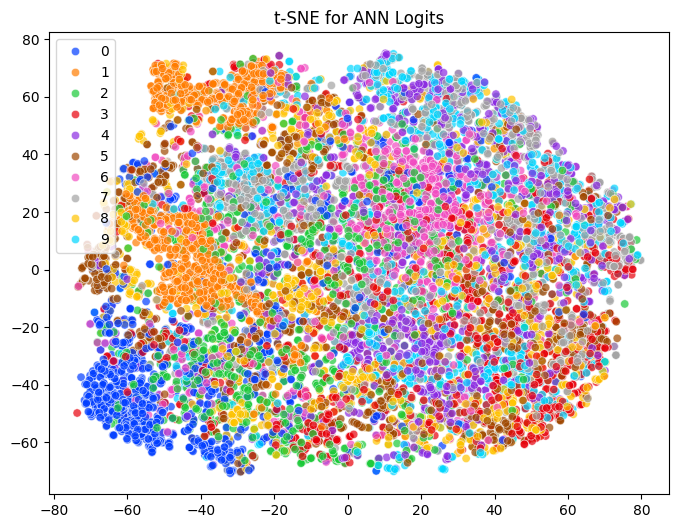

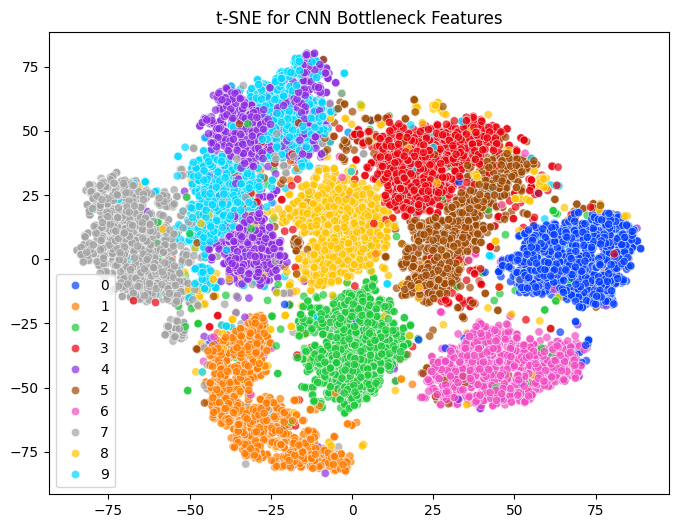

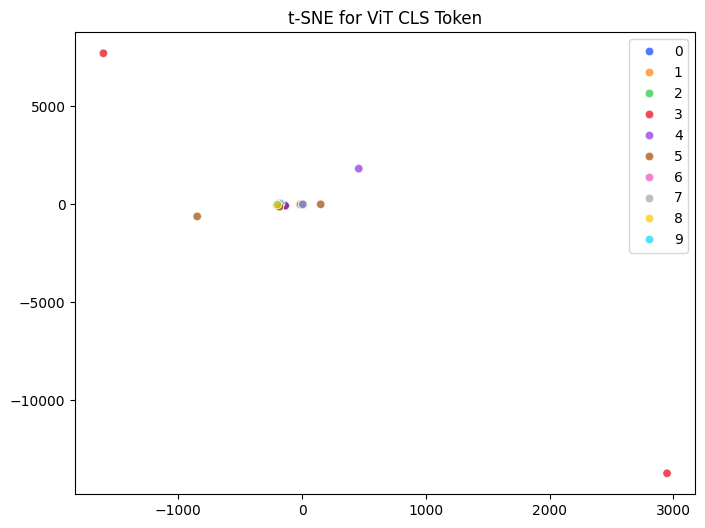

In [40]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
import numpy as np

def plot_tsne(features, labels, title="t-SNE Visualization"):
    tsne = TSNE(n_components=2, random_state=42)
    reduced_features = tsne.fit_transform(features)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], hue=labels, palette="bright", alpha=0.7)
    plt.title(title)
    plt.legend()
    plt.show()

def extract_features(model, dataloader, feature_type="logits"):
    model.eval()
    all_features, all_labels = [], []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to("cuda")
            labels = labels.to("cuda")

            if feature_type == "logits":
                outputs,_,_ = model(images)  # ANN
            elif feature_type == "bottleneck":
                _, outputs,_ = model(images)  # CNN
            elif feature_type == "cls":
                _, outputs,_ = model(images)  # ViT
            
            all_features.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    return np.concatenate(all_features, axis=0), np.concatenate(all_labels, axis=0)

# Assuming `test_loader` is your test dataloader
ann_features, ann_labels = extract_features(ann_model, test_loader, "logits")
cnn_features, cnn_labels = extract_features(cnn_model, test_loader, "bottleneck")
vit_features, vit_labels = extract_features(vit_model, test_loader, "cls")

plot_tsne(ann_features, ann_labels, "t-SNE for ANN Logits")
plot_tsne(cnn_features, cnn_labels, "t-SNE for CNN Bottleneck Features")
plot_tsne(vit_features, vit_labels, "t-SNE for ViT CLS Token")

Shape of first convolutional layer feature maps: torch.Size([1, 32, 28, 28])
Shape of second convolutionlayer feature maps: torch.Size([1, 64, 14, 14])


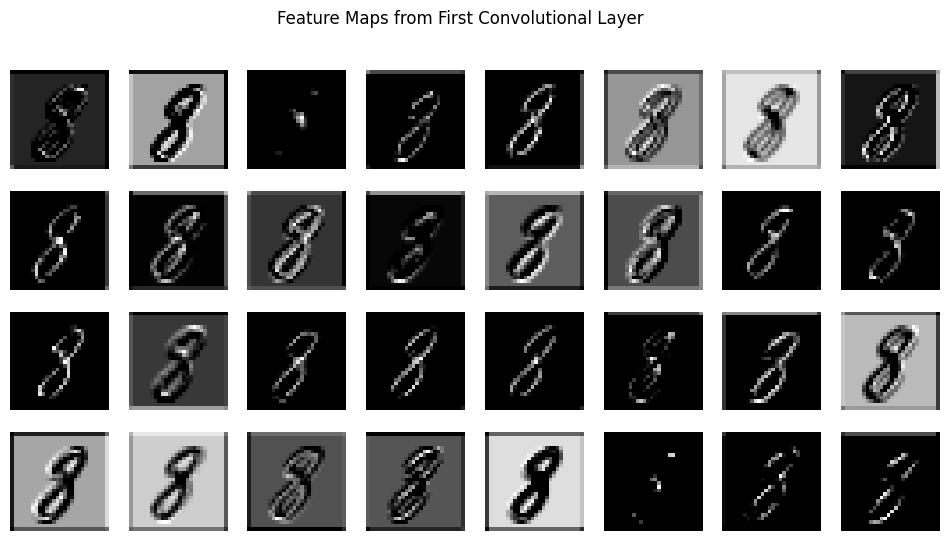

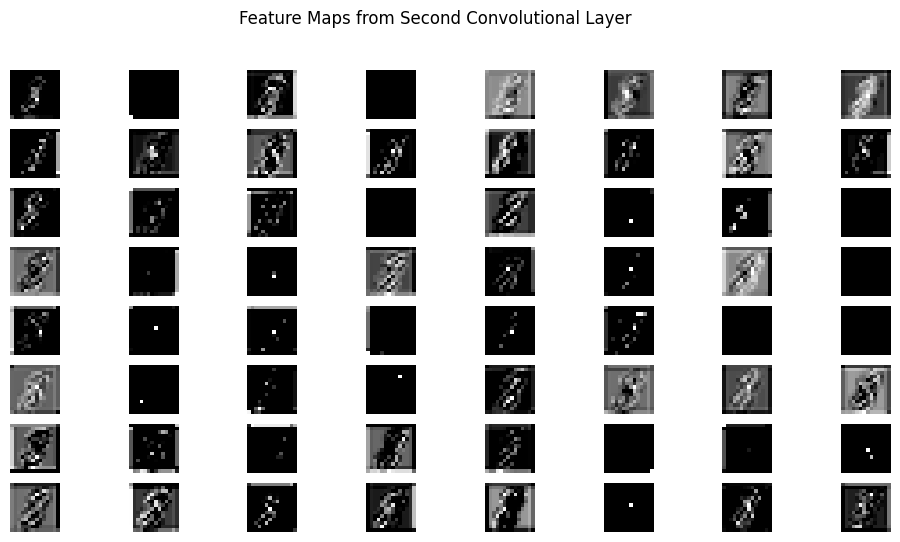

In [66]:
import matplotlib.pyplot as plt
def visualize_cnn_features(model, image):
    model.eval()
    image = image.unsqueeze(0).to("cuda")  # Add batch dimension and move to GPU
    _,_, feature_maps = model(image)
    print(f"Shape of first convolutional layer feature maps: {feature_maps[0].shape}")
    print(f"Shape of second convolutionlayer feature maps: {feature_maps[1].shape}")
    fig, axes = plt.subplots(4, 8, figsize=(12, 6))
    axes = axes.flatten()
    for i in range(32):  # First conv layer has 32 filters
        axes[i].imshow(feature_maps[0][0, i].cpu().detach().numpy(), cmap="gray")
        axes[i].axis("off")

    plt.suptitle("Feature Maps from First Convolutional Layer")
    plt.show()
    fig2, axes2 = plt.subplots(8, 8, figsize=(12, 6))
    axes2 = axes2.flatten()
    for i in range(64):  # Second conv layer has 64 filters
        axes2[i].imshow(feature_maps[1][0, i].cpu().detach().numpy(), cmap="gray")
        axes2[i].axis("off")
    plt.suptitle("Feature Maps from Second Convolutional Layer")
    plt.show()

sample_image, _ = next(iter(test_loader))
sample_image = sample_image[5]  # Take one image from batch
visualize_cnn_features(cnn_model, sample_image)

Shape of feature maps from each transformer block:
Layer 1: torch.Size([1, 17, 64])
Layer 2: torch.Size([1, 17, 64])
Shape of the feature map: (16, 64)


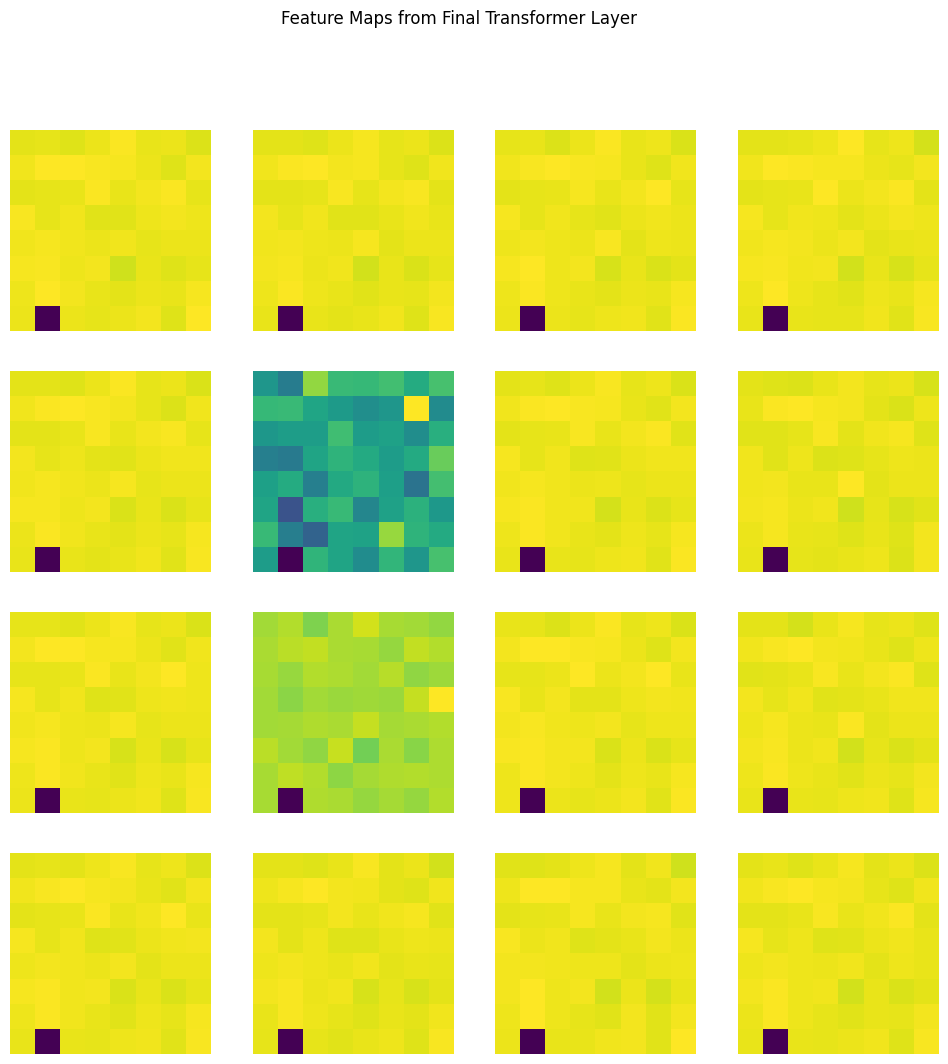

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def visualize_vit_features(model, image):
    # Ensure the model is on the same device as the input image
    device = image.device  # Get the device from the image tensor
    model = model.to(device)  # Move the model to the same device

    model.eval()
    image = image.unsqueeze(0).to(device)  # Add batch dimension and move image to the correct device

    logits, cls_token, feature_maps = model(image)

    print(f"Shape of feature maps from each transformer block:")
    for i, fmap in enumerate(feature_maps):
        print(f"Layer {i+1}: {fmap.shape}")

    # Visualize the feature maps from the final transformer layer
    final_feature_map = feature_maps[-1]  # Get the feature map after the last transformer layer
    feature_map = final_feature_map[0, 1:].cpu().detach().numpy()  # Exclude CLS token and convert to numpy

    # Inspect the shape of the feature map before reshaping
    print(f"Shape of the feature map: {feature_map.shape}")
    num_features = feature_map.shape[0]  # Number of patches (features)
    # Calculate the grid size based on the number of features
    grid_size = int(np.sqrt(num_features))
    # Create a grid of feature maps
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))
    axes = axes.flatten()
    for i in range(num_features):
        # Reshape feature map[i] to a square shape. The patch size will vary depending on your model configuration
        patch_size = int(np.sqrt(feature_map[i].shape[0]))  # Assuming it's a flattened patch, calculate the side length
        axes[i].imshow(feature_map[i].reshape(patch_size, patch_size), cmap="viridis")
        axes[i].axis("off")
    plt.suptitle("Feature Maps from Final Transformer Layer")
    plt.show()
# Sample image from the dataset (ensure the image is on the right device)
sample_image, _ = next(iter(test_loader))
sample_image = sample_image[5]  # Take one image from batch

# Visualize ViT feature maps
visualize_vit_features(vit_model, sample_image)

It is observed that Vision Transformers (ViTs) performed worse than CNNs and ANNs on MNIST. The reasons can be follwing
* ViT Requires More Data to Generalize Well
-- MNIST has only 60,000 training images, which is not enough for ViTs to generalize well.
* Lack of Inductive Bias in ViT
* Patch Embedding in ViT Loses Fine-Grained Details
* ViT also requires more epochs to get trained properly but due to device constraints trained with 25 epochs

# MNIST Autoencoder:

In [264]:
import torch
import torch.nn as nn

class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1),  # 28x28 → 14x14
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1), # 14x14 → 7x7
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),  # 7x7 → 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, kernel_size=3, stride=2, padding=1, output_padding=1),   # 14x14 → 28x28
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [265]:
sample_image, _ = next(iter(test_loader))
sample_image = sample_image[5]  # Take
print(f"Sample image shape: {sample_image.shape}")
small_cae = CAE()

for model in [small_cae]:
    model.eval()
    image = sample_image.unsqueeze(0)
    output = model(image)
    print(f"Output shape for {model.__class__.__name__}: {output.shape}")

Sample image shape: torch.Size([1, 28, 28])
Output shape for CAE: torch.Size([1, 1, 28, 28])


In [267]:
# Training function
def train_model(model, num_epochs=25):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        total_loss = 0
        for images, _ in train_loader:
            images = images.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.6f}")

# Train each model
print("\nTraining SmallCAE:")
cae_model = CAE()
train_model(cae_model)



Training SmallCAE:
Epoch [1/25], Loss: 0.961954
Epoch [2/25], Loss: 0.847524
Epoch [3/25], Loss: 0.840490
Epoch [4/25], Loss: 0.838948
Epoch [5/25], Loss: 0.837937
Epoch [6/25], Loss: 0.837170
Epoch [7/25], Loss: 0.836653
Epoch [8/25], Loss: 0.836248
Epoch [9/25], Loss: 0.835925
Epoch [10/25], Loss: 0.835591
Epoch [11/25], Loss: 0.835324
Epoch [12/25], Loss: 0.835028
Epoch [13/25], Loss: 0.834739
Epoch [14/25], Loss: 0.834533
Epoch [15/25], Loss: 0.834376
Epoch [16/25], Loss: 0.834211
Epoch [17/25], Loss: 0.834089
Epoch [18/25], Loss: 0.833994
Epoch [19/25], Loss: 0.833920
Epoch [20/25], Loss: 0.833827
Epoch [21/25], Loss: 0.833745
Epoch [22/25], Loss: 0.833693
Epoch [23/25], Loss: 0.833646
Epoch [24/25], Loss: 0.833622
Epoch [25/25], Loss: 0.833583



CAE Reconstruction:


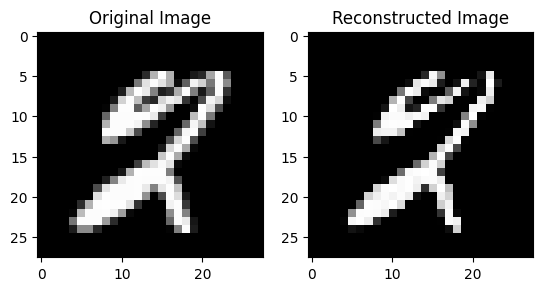

In [269]:
import matplotlib.pyplot as plt

def visualize_reconstruction(model, dataset):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    images, _ = next(iter(DataLoader(dataset, batch_size=1)))
    images = images.to(device)
    with torch.no_grad():
        reconstructed = model(images)
    images, reconstructed = images.cpu(), reconstructed.cpu()

    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(images[0][0], cmap='gray')
    axes[0].set_title("Original Image")
    axes[1].imshow(reconstructed[0][0], cmap='gray')
    axes[1].set_title("Reconstructed Image")
    plt.show()

# Test and visualize the reconstructions
print("\nCAE Reconstruction:")
visualize_reconstruction(cae_model, train_dataset)

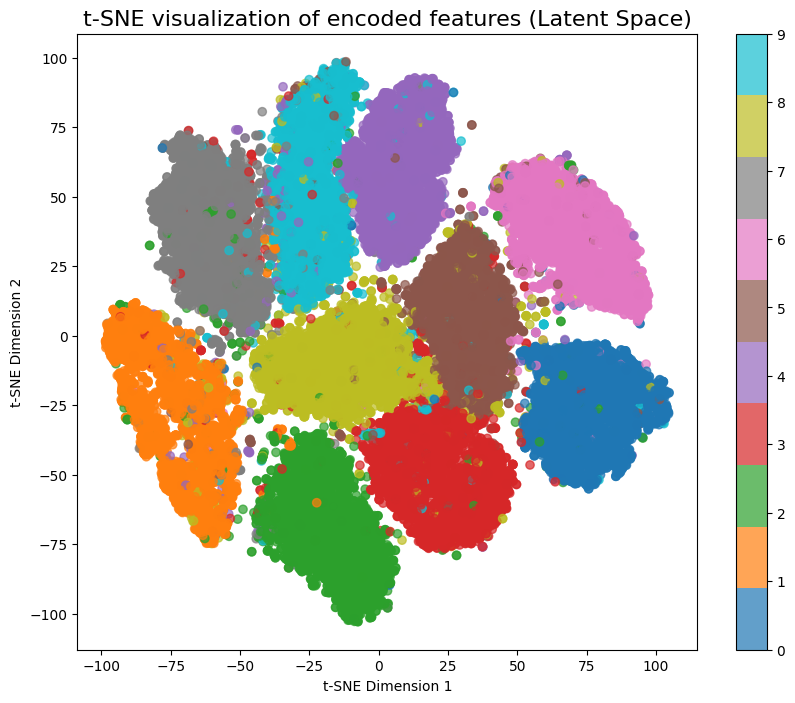

In [270]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder

# Function to extract encoded features from the model
def extract_encoded_features(model, dataset, device):
    model.eval()
    encoded_features = []
    labels = []
    with torch.no_grad():
        for images, targets in DataLoader(dataset, batch_size=64):
            images = images.to(device)
            targets = targets.numpy()
            encoded = model.encoder(images)  # Extract features from encoder
            encoded = encoded.view(encoded.size(0), -1)  # Flatten the encoded features
            encoded_features.append(encoded.cpu().numpy())
            labels.append(targets)

    # Concatenate all extracted features and labels
    encoded_features = np.concatenate(encoded_features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return encoded_features, labels

# Function to apply t-SNE and plot the results
def plot_tsne(encoded_features, labels):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(encoded_features)

    # Plot t-SNE results
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter)
    plt.title("t-SNE visualization of encoded features (Latent Space)", fontsize=16)
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()

# Extract encoded features from the MediumCAE model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoded_features, labels = extract_encoded_features(cae_model, train_dataset, device)

# Visualize the encoded features using t-SNE
plot_tsne(encoded_features, labels)

In [174]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Function to add Gaussian noise
def add_gaussian_noise(images, sigma):
    noise = torch.randn_like(images) * sigma / 255.0  # Normalized to [0,1]
    noisy_images = images + noise
    noisy_images = torch.clamp(noisy_images, 0.0, 1.0)  # Ensure valid image range
    return noisy_images

In [167]:
# Function to train the Denoising CAE
def train_denoising_cae(model, train_loader, sigma, num_epochs=10, learning_rate=1e-3):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for images, _ in train_loader:
            noisy_images = add_gaussian_noise(images, sigma).to(device)
            clean_images = images.to(device)

            optimizer.zero_grad()
            outputs = model(noisy_images)
            loss = criterion(outputs, clean_images)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.6f}")

In [171]:
# Function to calculate PSNR and SSIM for a pair of images
def evaluate_denoising(model, noisy_images, clean_images):
    model.eval()
    with torch.no_grad():
        outputs = model(noisy_images.to(device))

    # Convert tensors to numpy for evaluation
    noisy_images = noisy_images.cpu().numpy().squeeze()
    clean_images = clean_images.cpu().numpy().squeeze()
    outputs = outputs.cpu().numpy().squeeze()

    # Calculate PSNR and SSIM for each image
    psnr_value = psnr(clean_images, outputs)
    ssim_value = ssim(clean_images, outputs, data_range=1.0)  # Specify data_range for SSIM

    return psnr_value, ssim_value

In [169]:
# Function to display noisy and denoised images
def visualize_denoising(noisy_images, denoised_images, clean_images):
    fig, axes = plt.subplots(3, 5, figsize=(10, 6))

    for i in range(5):
        axes[0, i].imshow(noisy_images[i].cpu().numpy().squeeze(), cmap='gray')
        axes[0, i].set_title("Noisy")
        axes[0, i].axis('off')

        axes[1, i].imshow(clean_images[i].cpu().numpy().squeeze(), cmap='gray')
        axes[1, i].set_title("Clean")
        axes[1, i].axis('off')

        axes[2, i].imshow(denoised_images[i].cpu().numpy().squeeze(), cmap='gray')
        axes[2, i].set_title("Denoised")
        axes[2, i].axis('off')

    plt.show()

Training Denoising CAE with noise level σ=1...
Epoch [1/10], Loss: 0.833944
Epoch [2/10], Loss: 0.833921
Epoch [3/10], Loss: 0.833875
Epoch [4/10], Loss: 0.833876
Epoch [5/10], Loss: 0.833819
Epoch [6/10], Loss: 0.833799
Epoch [7/10], Loss: 0.833785
Epoch [8/10], Loss: 0.833728
Epoch [9/10], Loss: 0.833719
Epoch [10/10], Loss: 0.833699


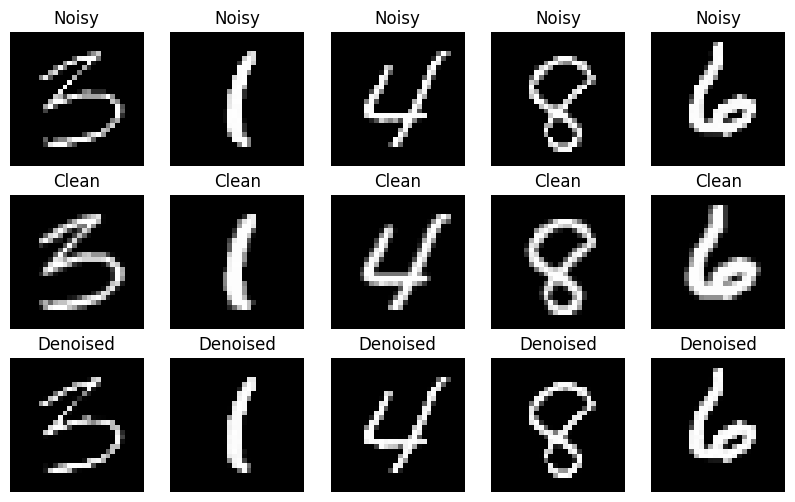

PSNR: 6.77, SSIM: -0.3075
Training Denoising CAE with noise level σ=5...
Epoch [1/10], Loss: 0.833741
Epoch [2/10], Loss: 0.833693
Epoch [3/10], Loss: 0.833687
Epoch [4/10], Loss: 0.833681
Epoch [5/10], Loss: 0.833658
Epoch [6/10], Loss: 0.833642
Epoch [7/10], Loss: 0.833636
Epoch [8/10], Loss: 0.833646
Epoch [9/10], Loss: 0.833612
Epoch [10/10], Loss: 0.833632


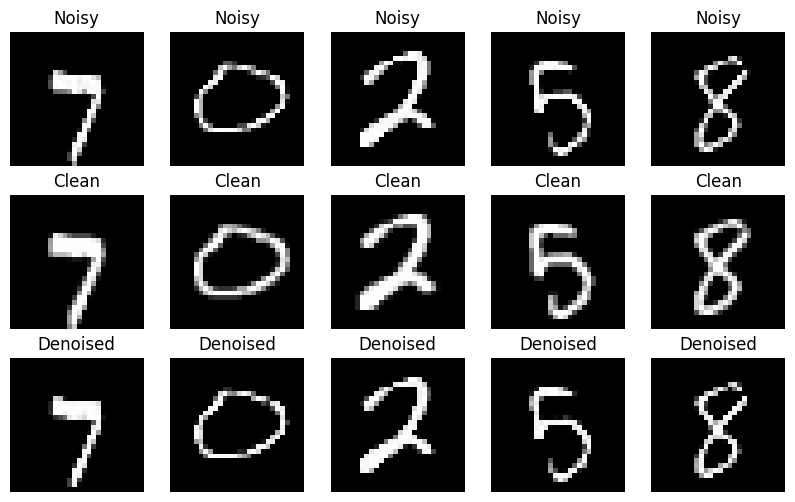

PSNR: 6.85, SSIM: -0.3237
Training Denoising CAE with noise level σ=10...
Epoch [1/10], Loss: 0.833675
Epoch [2/10], Loss: 0.833667
Epoch [3/10], Loss: 0.833666
Epoch [4/10], Loss: 0.833644
Epoch [5/10], Loss: 0.833636
Epoch [6/10], Loss: 0.833633
Epoch [7/10], Loss: 0.833651
Epoch [8/10], Loss: 0.833623
Epoch [9/10], Loss: 0.833624
Epoch [10/10], Loss: 0.833621


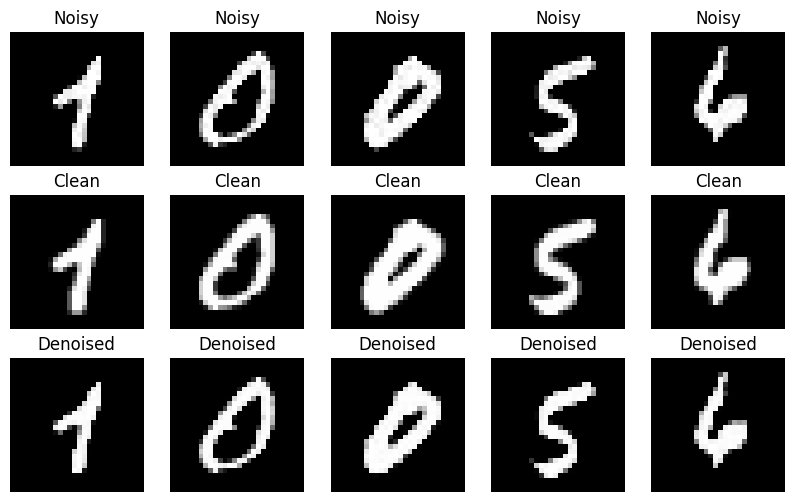

PSNR: 6.79, SSIM: -0.2886
Training Denoising CAE with noise level σ=15...
Epoch [1/10], Loss: 0.833730
Epoch [2/10], Loss: 0.833713
Epoch [3/10], Loss: 0.833713
Epoch [4/10], Loss: 0.833705
Epoch [5/10], Loss: 0.833706
Epoch [6/10], Loss: 0.833697
Epoch [7/10], Loss: 0.833697
Epoch [8/10], Loss: 0.833691
Epoch [9/10], Loss: 0.833672
Epoch [10/10], Loss: 0.833643


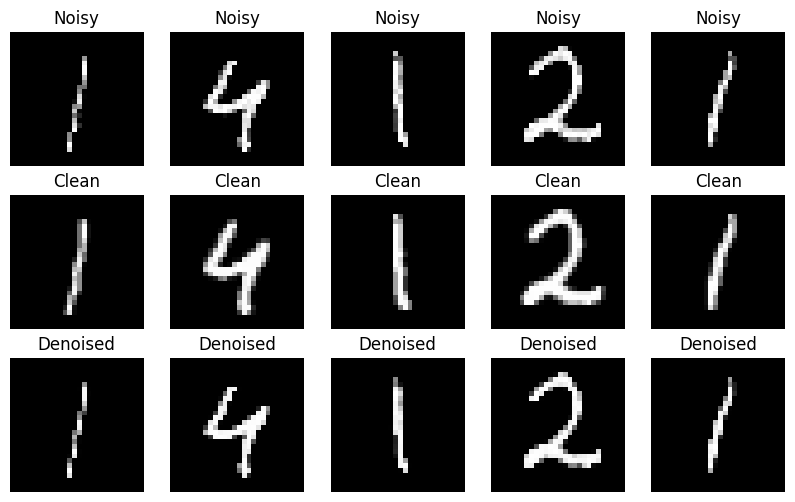

PSNR: 6.79, SSIM: -0.3249


In [ ]:
# Train and evaluate the denoising CAE for different noise levels
for sigma in [1, 5, 10, 15]:
    print(f"Training Denoising CAE with noise level σ={sigma}...")
    # Train the model
    train_denoising_cae(cae_model, train_loader, sigma)

    # Evaluate the model on some noisy images
    sample_images, sample_labels = next(iter(train_loader))
    noisy_images = add_gaussian_noise(sample_images, sigma).to(device)
    clean_images = sample_images.to(device)

    # Display noisy and denoised images
    with torch.no_grad():
        denoised_images = cae_model(noisy_images)

    visualize_denoising(noisy_images, denoised_images, clean_images)

    # Calculate PSNR and SSIM
    psnr_value, ssim_value = evaluate_denoising(cae_model, noisy_images, clean_images)
    print(f"PSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}")

In [ ]:
sample_images, sample_labels = next(iter(DataLoader(train_dataset, batch_size=64)))
clean_images = sample_images.to(device)
noisy_images_1 = add_gaussian_noise(clean_images, sigma=1).to(device)
noisy_images_5 = add_gaussian_noise(clean_images, sigma=5).to(device)
noisy_images_10 = add_gaussian_noise(clean_images, sigma=10).to(device)
noisy_images_15 = add_gaussian_noise(clean_images, sigma=15).to(device)


In [278]:
def extract_latent_representations(model, noisy_images, device):
    model.eval()  # Set model to evaluation mode
    noisy_images = noisy_images.to(device)
    with torch.no_grad():
        latent_representations = model.encoder(noisy_images)
    return latent_representations

latent_denoised_1 = extract_latent_representations(cae_model, noisy_images_5, device)
latent_denoised_1_flattened = latent_denoised_1.view(latent_denoised_1.size(0), -1).cpu().detach().numpy()
latent_denoised_5 = extract_latent_representations(cae_model, noisy_images_5, device)
latent_denoised_5_flattened = latent_denoised_5.view(latent_denoised_5.size(0), -1).cpu().detach().numpy()
latent_denoised_10 = extract_latent_representations(cae_model, noisy_images_10, device)
latent_denoised_10_flattened = latent_denoised_10.view(latent_denoised_10.size(0), -1).cpu().detach().numpy()
latent_denoised_15 = extract_latent_representations(cae_model, noisy_images_15, device)
latent_denoised_15_flattened = latent_denoised_15.view(latent_denoised_15.size(0), -1).cpu().detach().numpy()
latent_cae = extract_latent_representations(cae_model, clean_images, device)  # Vanilla CAE with clean images
latent_cae_flattened = latent_cae.view(latent_cae.size(0), -1).cpu().detach().numpy()
print(f"latent_denoised_1 shape: {latent_denoised_1.shape}")
print(f"latent_denoised_5 shape: {latent_denoised_5.shape}")
print(f"latent_denoised_10 shape: {latent_denoised_10.shape}")
print(f"latent_denoised_15 shape: {latent_denoised_15.shape}")
print(f"latent_cae shape: {latent_cae.shape}")
print(f"labels shape: {labels.shape}")

latent_denoised_1 shape: torch.Size([64, 16, 7, 7])
latent_denoised_5 shape: torch.Size([64, 16, 7, 7])
latent_denoised_10 shape: torch.Size([64, 16, 7, 7])
latent_denoised_15 shape: torch.Size([64, 16, 7, 7])
latent_cae shape: torch.Size([64, 16, 7, 7])
labels shape: (42000,)


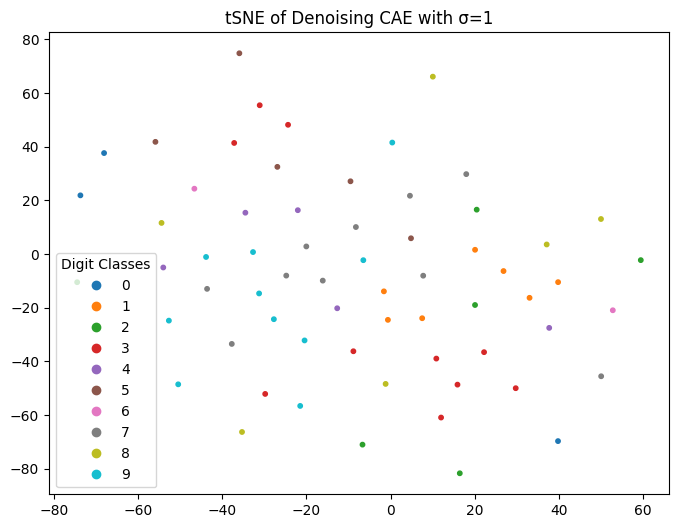

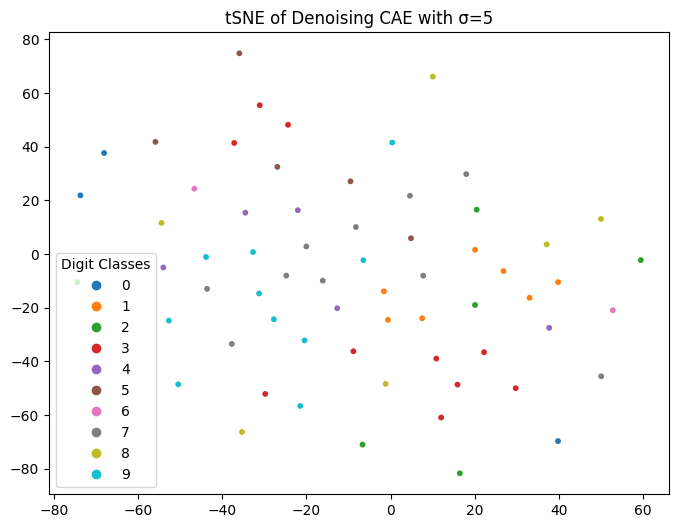

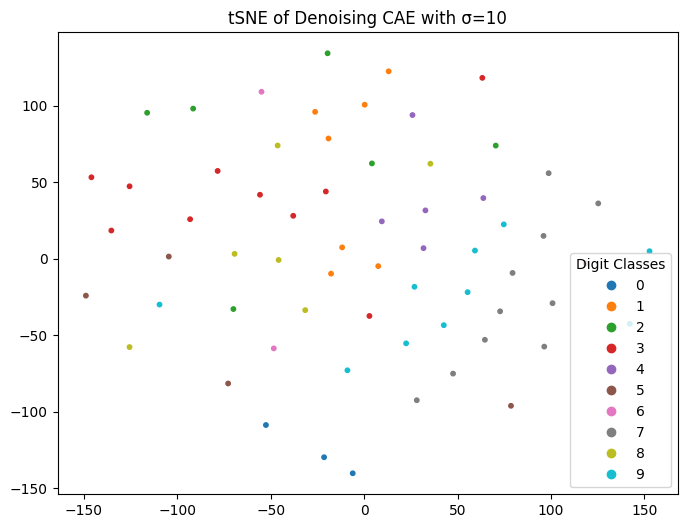

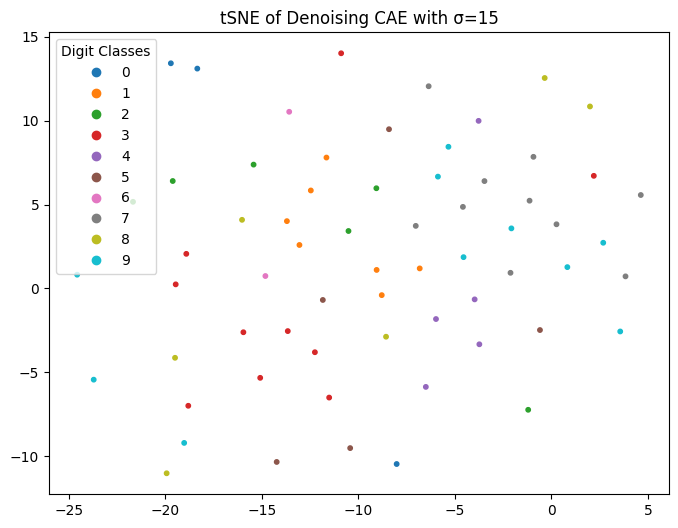

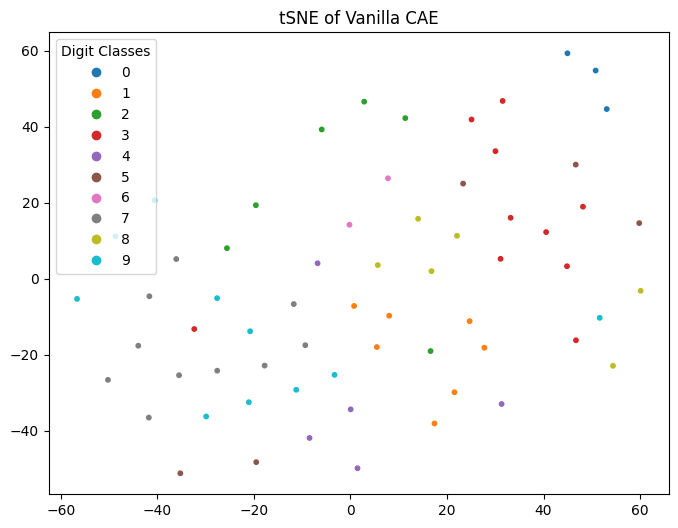

In [280]:
def plot_tsne(latent, labels, title):
    # Initialize TSNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
    # Perform tSNE transformation
    latent_2d = tsne.fit_transform(latent)
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10', s=10)
    plt.legend(handles=scatter.legend_elements()[0], labels=[str(i) for i in range(10)], title="Digit Classes")
    plt.title(title)
    plt.show()
# Now, call plot_tsne with your data

plot_tsne(latent_denoised_1_flattened, labels[:len(latent_denoised_1)], "tSNE of Denoising CAE with σ=1")
plot_tsne(latent_denoised_5_flattened, labels[:len(latent_denoised_5)], "tSNE of Denoising CAE with σ=5")
plot_tsne(latent_denoised_10_flattened, labels[:len(latent_denoised_10)], "tSNE of Denoising CAE with σ=10")
plot_tsne(latent_denoised_15_flattened, labels[:len(latent_denoised_15)], "tSNE of Denoising CAE with σ=15")
plot_tsne(latent_cae_flattened, labels[:len(latent_cae)], "tSNE of Vanilla CAE")

Outputs of clean images were potrayed well in tsne rather than noisy images.

Link to the prompts used :
https://chatgpt.com/share/67b37d96-1dbc-800d-8972-9d597554ffb1